# Transfer_Learning_MobileNet2_SGD_300_epochs

In [ ]:
#!pip install sklearn
#!pip install imutils

In [1]:
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2

from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader

import matplotlib.pyplot as plt
import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Empezamos el entrenamiento

In [20]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pyimagesearch.preprocessing import ImageToArrayPreprocessor
from pyimagesearch.preprocessing import AspectAwarePreprocessor
from pyimagesearch.datasets import SimpleDatasetLoader

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from imutils import paths
import numpy as np
import os
import cv2

# Leemos la data

In [21]:
img_size = 224
path_train = 'data_' + str(img_size) + '/train'
path_validation = 'data_' + str(img_size) + '/validation'
path_checkpoints = 'checkpoint_MobileNet'

In [5]:
imagePaths_train = list(paths.list_images(path_train))
imagePaths_validation = list(paths.list_images(path_validation))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths_train]
classNames = [str(x) for x in np.unique(classNames)]

print("etiquetas del entrenamiento")
print(classNames)

#Códificando las etiquetas en númerops
print("codificando etiquetas")
le = LabelEncoder()
classNames_ids = le.fit_transform(classNames)
print(classNames_ids)

etiquetas del entrenamiento
['10', '100', '20', '200', '50']
codificando etiquetas
[0 1 2 3 4]


In [6]:
iap = ImageToArrayPreprocessor()
sdl = SimpleDatasetLoader(preprocessors=[iap])

print('Cargando data para el entrenamiento')
data_train, labels_train = sdl.load(imagePaths_train, verbose=5000)

print('Cargando data para la validación')
data_validation, labels_validation = sdl.load(imagePaths_validation, verbose=500)

print('Binarizando los labels')
labels_train = LabelBinarizer().fit_transform(labels_train)
labels_validation = LabelBinarizer().fit_transform(labels_validation)

print('Carga terminada')


Cargando data para el entrenamiento
[INFO] processed 5000/23975
[INFO] processed 10000/23975
[INFO] processed 15000/23975
[INFO] processed 20000/23975
Cargando data para la validación
[INFO] processed 500/1515
[INFO] processed 1000/1515
[INFO] processed 1500/1515
Binarizando los labels
Carga terminada


# Creando el modelo base

In [7]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size,img_size,3)
)

# Congelamos las capas para el entrenamiento

In [44]:
for layer in base_model.layers:
    layer.trainable = True

# Creamos la nueva cabecera

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense

# Creamos varios modelos para luego realizar un ensamblaje

In [46]:
path_ensembles = 'ensembles_MobileNetV2'
batch_size = 32
epochs = 100

# Entrenamiento

In [ ]:
'''
print('Normalizando los datos')
data_train = data_train.astype("float") / 255.0
data_validation = data_validation.astype("float") / 255.0

print('Generando la data para el entrenamiento')
aug_train = ImageDataGenerator()
aug_train.fit(data_train)
train_generator = aug_train.flow(data_train, labels_train, batch_size=batch_size)

aug_validation = ImageDataGenerator()
aug_validation.fit(data_validation)
validation_generator = aug_validation.flow(data_validation, labels_validation, batch_size=batch_size)
print('Terminado')
'''

In [11]:
aug_train = ImageDataGenerator(rescale=1. / 255)
aug_train.fit(data_train)
train_generator = aug_train.flow_from_directory(path_train,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size)

Found 23975 images belonging to 5 classes.


In [13]:
aug_validation = ImageDataGenerator(rescale=1. / 255)
aug_validation.fit(data_validation)
validation_generator = aug_validation.flow_from_directory(path_validation,
                                                          target_size=(img_size, img_size),
                                                          batch_size=batch_size)

Found 1515 images belonging to 5 classes.


In [47]:
model = tf.keras.Sequential([
                              base_model,
                              Flatten(),
                              Dense(1024, activation='relu'),
                              Dense(1024, activation='relu'),
                              Dense(1024, activation='relu'),
                              Dropout(0.2),
                              Dense(512, activation='relu'),
                              Dense(512, activation='relu'),
                              Dense(512, activation='relu'),
                              Dropout(0.2),
                              Dense(128, activation='relu'),
                              Dense(128, activation='relu'),
                              Dense(128, activation='relu'),
                              Dropout(0.2),
                              Dense(64, activation='relu'),
                              Dense(32, activation='relu'),
                              Dense(len(classNames_ids), activation='softmax')
                            ])

In [48]:
#optimizer = Adam(learning_rate=0.0001)
optimizer = SGD(learning_rate=0.0001)

loss = 'categorical_crossentropy'
metrics=["accuracy"]

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)


# Configurando checkpoint

In [49]:
fname = os.path.sep.join([path_checkpoints, 
                          'epoch-{epoch:03d}-val_loss:{val_loss:.4f}-val_accuracy:{val_accuracy:.4f}.hdf5'])
checkpoint = ModelCheckpoint(fname,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
callbacks = [checkpoint]

In [50]:
#entrenando el modelo
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              validation_data=validation_generator,
                              epochs = epochs,
                              callbacks=callbacks,
                              verbose = 1)

Epoch 1/100
750/750 [==============================] - ETA: 0s - loss: 1.6101 - accuracy: 0.2108
Epoch 00001: val_accuracy improved from -inf to 0.20528, saving model to checkpoint_MobileNet/epoch-001-val_loss:1.6097-val_accuracy:0.2053.hdf5
750/750 [==============================] - 103s 138ms/step - loss: 1.6101 - accuracy: 0.2108 - val_loss: 1.6097 - val_accuracy: 0.2053
Epoch 2/100
750/750 [==============================] - ETA: 0s - loss: 1.5921 - accuracy: 0.2250
Epoch 00002: val_accuracy improved from 0.20528 to 0.21056, saving model to checkpoint_MobileNet/epoch-002-val_loss:1.6027-val_accuracy:0.2106.hdf5
750/750 [==============================] - 102s 136ms/step - loss: 1.5921 - accuracy: 0.2250 - val_loss: 1.6027 - val_accuracy: 0.2106
Epoch 3/100
750/750 [==============================] - ETA: 0s - loss: 1.5679 - accuracy: 0.2408
Epoch 00003: val_accuracy improved from 0.21056 to 0.21188, saving model to checkpoint_MobileNet/epoch-003-val_loss:1.5911-val_accuracy:0.2119.hdf

Epoch 23/100
750/750 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9915
Epoch 00023: val_accuracy did not improve from 0.77624
750/750 [==============================] - 102s 136ms/step - loss: 0.0296 - accuracy: 0.9915 - val_loss: 0.7743 - val_accuracy: 0.7736
Epoch 24/100
750/750 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9923
Epoch 00024: val_accuracy improved from 0.77624 to 0.77888, saving model to checkpoint_MobileNet/epoch-024-val_loss:0.7891-val_accuracy:0.7789.hdf5
750/750 [==============================] - 103s 137ms/step - loss: 0.0277 - accuracy: 0.9923 - val_loss: 0.7891 - val_accuracy: 0.7789
Epoch 25/100
750/750 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9935
Epoch 00025: val_accuracy did not improve from 0.77888
750/750 [==============================] - 103s 137ms/step - loss: 0.0248 - accuracy: 0.9935 - val_loss: 0.8185 - val_accuracy: 0.7749
Epoch 26/100
750/750 [=====================

750/750 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9971
Epoch 00050: val_accuracy did not improve from 0.78680
750/750 [==============================] - 103s 137ms/step - loss: 0.0106 - accuracy: 0.9971 - val_loss: 0.9595 - val_accuracy: 0.7756
Epoch 51/100
750/750 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9974
Epoch 00051: val_accuracy did not improve from 0.78680
750/750 [==============================] - 103s 137ms/step - loss: 0.0098 - accuracy: 0.9974 - val_loss: 0.9333 - val_accuracy: 0.7809
Epoch 52/100
750/750 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9986
Epoch 00052: val_accuracy did not improve from 0.78680
750/750 [==============================] - 103s 137ms/step - loss: 0.0074 - accuracy: 0.9986 - val_loss: 0.9307 - val_accuracy: 0.7809
Epoch 53/100
750/750 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.9979
Epoch 00053: val_accuracy did not improve from 0.78

Epoch 79/100
750/750 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9985
Epoch 00079: val_accuracy did not improve from 0.78680
750/750 [==============================] - 102s 136ms/step - loss: 0.0053 - accuracy: 0.9985 - val_loss: 1.0571 - val_accuracy: 0.7663
Epoch 80/100
750/750 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9987
Epoch 00080: val_accuracy did not improve from 0.78680
750/750 [==============================] - 102s 136ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 1.0416 - val_accuracy: 0.7782
Epoch 81/100
750/750 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9987
Epoch 00081: val_accuracy did not improve from 0.78680
750/750 [==============================] - 102s 136ms/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 1.0608 - val_accuracy: 0.7776
Epoch 82/100
750/750 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9990
Epoch 00082: val_accuracy did not impr

In [51]:
#guardando el modelo
p = [path_ensembles, "model_100_SGD.model"]
model.save(os.path.sep.join(p))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ensembles_MobileNetV2/model_100_SGD.model/assets


In [52]:
#evaluando el modelo
predictions = model.predict(data_validation, batch_size=batch_size)
print(classification_report(labels_validation.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=classNames))

              precision    recall  f1-score   support

          10       0.16      0.54      0.24       305
         100       0.10      0.11      0.10       302
          20       0.17      0.07      0.10       303
         200       0.00      0.00      0.00       302
          50       0.00      0.00      0.00       303

    accuracy                           0.14      1515
   macro avg       0.09      0.14      0.09      1515
weighted avg       0.09      0.14      0.09      1515



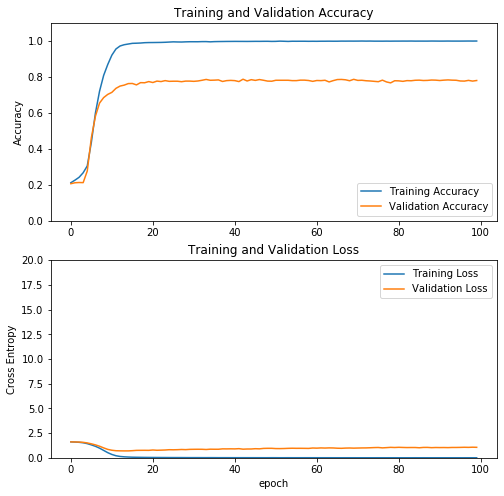

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.ylim([0,20])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Tomando 25 imágenes de validación y observando el resultado

INFO:tensorflow:Load image with size: 1515, num_label: 5, labels: 10, 100, 20, 200, 50.


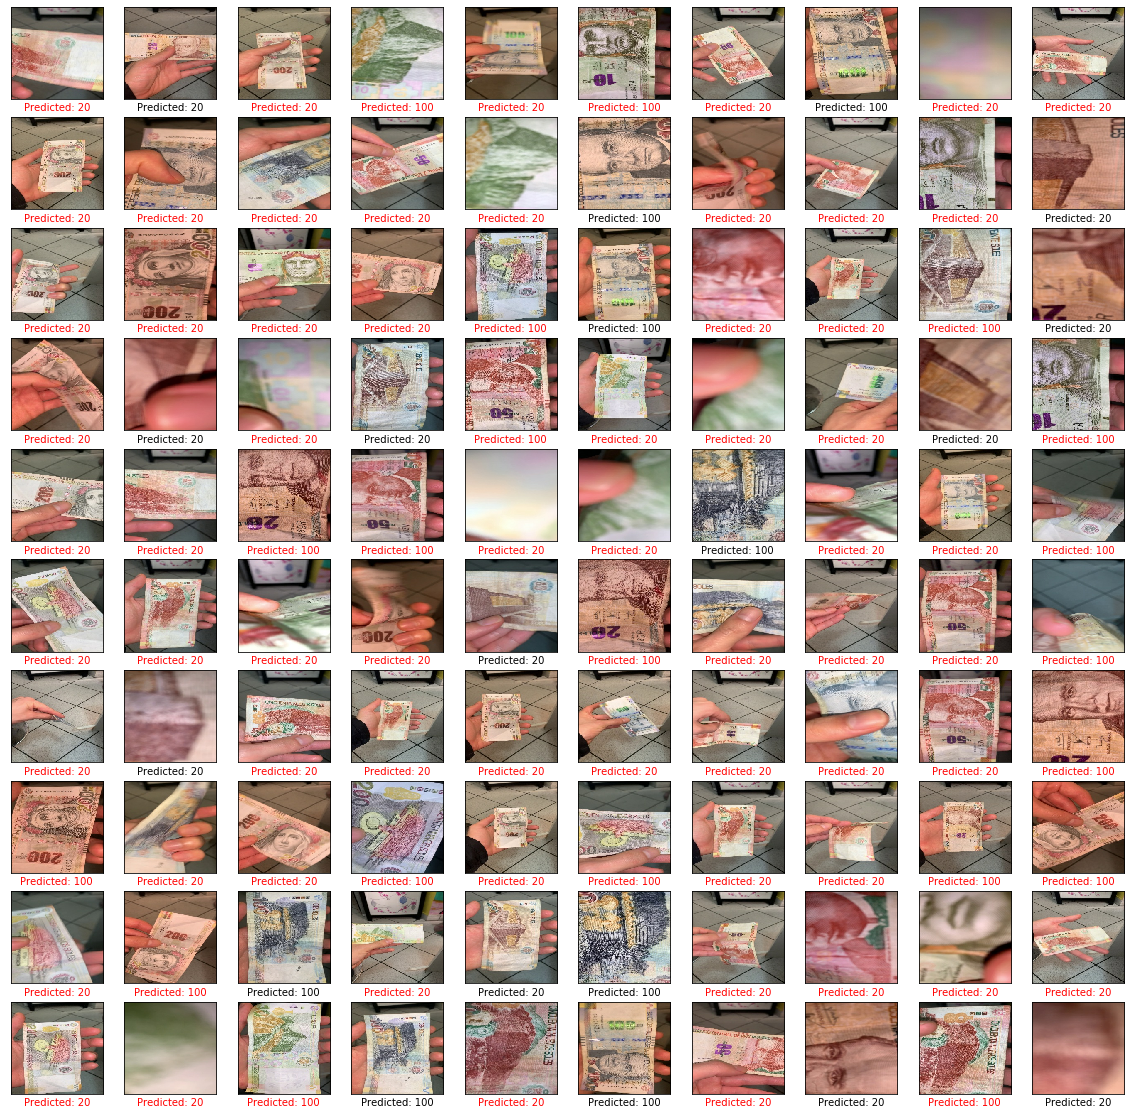

In [54]:
test_data = ImageClassifierDataLoader.from_folder(path_validation)

def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(test_data.dataset.take(100)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)

    swapped = np.moveaxis(image, 0, 1)
    arr4d = np.expand_dims(swapped, 0)
    id_predict = np.argmax(model.predict(arr4d))
    
    predict_label = "100"
    if id_predict == 1:
        predict_label = "20"
    color = get_label_color(predict_label, test_data.index_to_label[label.numpy()])
    #color = 'black'
    ax.xaxis.label.set_color(color)
    plt.xlabel('Predicted: %s' % predict_label)
plt.show()